In [19]:
video_path = 'primer_3.mp4'

In [20]:
import cv2
from matplotlib import pyplot as plt

In [4]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.8 MB/s 


In [21]:
import torch
from facenet_pytorch import MTCNN

class Singleton(type):
    _instances = {}

    
    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            cls._instances[cls] = super(Singleton,                                      cls).__call__(*args, **kwargs)
        return cls._instances[cls]


class Model(metaclass=Singleton):
    def __init__(self) -> None:
        self.model = torch.hub.load('ultralytics/yolov5', 'yolov5n', pretrained=True)


In [22]:
from collections import OrderedDict
import dataclasses
import secrets
import sys
from typing import Any, Dict, List, Optional, Set, Tuple, Union

Number = Union[int, float]

class Point:
    x: Number
    y: Number

    def __init__(self, x: Number, y: Number):
        self.x = x
        self.y = y

    def to_pair(self) -> Tuple[Number, Number]:
        return self.x, self.y

    def get_distance_to(self, other: 'Point') -> float:
        return ((self.x - other.x) ** 2 + (self.y - other.y) ** 2) ** 0.5

    def get_nearest_point(self, *args: 'TrackableObject') -> Tuple[Optional['TrackableObject'], Number]:
        result = None
        min = sys.maxsize
        for obj in args:
            distance = self.get_distance_to(obj.get_center())
            if distance < min:
                min = distance
                result = obj
        return (result, min)

    def __add__(self, other: 'Point') -> 'Point':
        return Point(self.x + other.x, self.y + other.y)

    def __sub__(self, other: 'Point') -> 'Point':
        return Point(self.x - other.x, self.y - other.y)

    def __truediv__(self, x: Number):
        return Point(self.x / x, self.y / x)

    def cross_product(self, other: 'Point') -> float:
        return self.x * other.y - self.y + other.x
    
    def __str__(self):
        return f'({self.x}, {self.y})'
    def __repr__(self):
        return f'({self.x}, {self.y})'

class Polygon:
    points: List[Point]
    
    def __init__(self, points: List[Point]):
        """
        points - список вершин по часовой стреллке
        """
        self.points = points

        self.inf = max(p.x for p in points)
    
    def area(self) -> float:
        """
        Разбиваем полигон на треугольники и ищем площадь многоугольника как
        сумму площадей треугольника.
        Площадь треугольника считаем по формуле Герона
        """
        S=0.0
        A = self.points[0]
        for i in range(2, len(self.points)):
            B = self.points[i-1]
            C = self.points[i]
            lengths = [A.get_distance_to(B), A.get_distance_to(C),
                       B.get_distance_to(C)]
            p=sum(lengths)/2
            S+=(p*(p-lengths[0])*(p-lengths[1])*(p-lengths[2]))**.5
        return S
    
    def ccw(self, A, B, C):
        return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)

    # Return true if line segments AB and CD intersect
    def intersect(self, A,B,C,D):
        return self.ccw(A,C,D) != self.ccw(B,C,D) and self.ccw(A,B,C) != self.ccw(A,B,D)

    def contains(self, point: Point) -> bool:
        result = False
        for i in range(len(self.points)-1):
            if self.intersect(
                self.points[i], self.points[i+1],
                point, Point(self.inf, point.y)
            ):
                result = not result
        if self.intersect(
            self.points[-1], self.points[0],
            point, Point(self.inf, point.y)
        ):
            result = not result
        return result

@dataclasses.dataclass
class State:
    inside: bool
    outside: bool
    was_inside: bool
    was_outside: bool
    reported_no: bool

class TrackableObject:
    point1: Point
    point2: Point
    frame_number: Optional[int]
    id: Any
    classes: list

    def __init__(
            self,
            point1: Point,
            point2: Point,
            frame_number: Optional[int] = None,
            id: Any = None
    ):
        if id is None:
            id = secrets.token_hex(8)
        self.point1 = point1
        self.point2 = point2
        self.frame_number = frame_number
        self.id = id
        self.classes = []

    def get_center(self) -> Point:
        return (self.point1 + self.point2) / 2

    def get_corners(self):
        """
        Returns:
            Список углов рамки вокруг объекта
        """
        return [
            self.point1,
            Point(self.point2.x, self.point1.y),
            self.point2,
            Point(self.point1.x, self.point2.y),
        ]

    def __repr__(self) -> str:
        return f"{self.id} {self.point1}--{self.point2}"


def get_centroid(box) -> Point:
    return Point((box[0].x + box[1].x) / 2, (box[0].y + box[1].y) / 2)


def get_bounding_box(
        frame: Any,
        frame_count: int,
        yolo_classes: list = [0]
) -> List[TrackableObject]:
    '''
    функция фильтрует боксы и выбирает только нужные классы
    в yolo 0 - это класс Person
    так же убирает метку класса и степень уверности
    остаются только координаты бокса
    '''
    list_of_people = []
    for i in frame.xyxy[0]:
        if len(i) == 0:
            continue
        if i[-1] in yolo_classes:
            list_of_people.append(TrackableObject(
                Point(float(i[0]), float(i[1])),
                Point(float(i[2]), float(i[3])),
                frame_count))
    return list_of_people


class CentroidTracker:
    # id который мы присвоим следующему появившемуся в кадре объекту
    next_id: int

    # максимум кадров которых объекта не должно быть выидно
    # чтобы считалось что он покинул область видимости
    max_disappeared: int

    # максимальная допустимая дистанция перемещения объекта за 1 кадр
    # если расстояние между центрами больше этого значения
    # считаем что появился новый объект, а не продолжает двигаться старый
    max_distance: int

    # ключи в словарях - id объекта

    # словарь со всеми отслеживаемыми объектами на данный момент
   

    # словарь с историей движения объекта по пикселям
    tracks: OrderedDict

    # словарь в котором для каждого объекта считается есть ли он в кадре
    # если его нет self.disappeared[id] += 1
    # если self.disappeared[id] > self.max_disappeared
    # то считаем что объект ушел и удаляем из self.objects
    # но в self.tracks история движеня объекта сохраняется
    disappeared: OrderedDict

    def __init__(self, max_disappeared=50, max_distance=50):
        self.next_id = 0
        self.max_disappeared = max_disappeared
        self.max_distance = max_distance

        self.objects = dict()
        self.tracks = dict()
        self.disappeared = dict()

    def add_object(self, centroid):
        """
        обнаружен новый объект
        """
        self.objects[self.next_id] = centroid
        self.objects[self.next_id].id = self.next_id
        self.tracks[self.next_id] = []
        self.disappeared[self.next_id] = 0
        self.next_id += 1

    def remove_object(self, id):
        '''
        объект ушел из кадра дольше чем на self.max_disappeared
        '''
        del self.objects[id]
        del self.disappeared[id]

    def remove_small_tracks(self, accept_length: int):
        '''
        функция удаляет все треки меньше заданного значения из истории
        self.tracks

        полезно в случаях когда случайно пиксели отрываются от трека в отдельный
        '''
        res = OrderedDict()
        for track_id in self.tracks.keys():
            if len(self.tracks[track_id]) > accept_length:
                res[track_id] = self.tracks[track_id]
        self.tracks = res

    def track(self, frame):
        
        '''
        функция отслеживает объекты на кадре
        на вход подается следующий кадр видео
        :return: словарь объектов в поле зрения на текущий момент
        '''

        # копируем кадр и объекты чтобы понять изменились ли объекты после работы функции
        current_frame = frame.copy()
        current_objects = self.objects.copy()
        # centers = {i.get_center(): i for i in frame}

        # TODO протестировать
        # если нет объектов на кадре - добавляем self.disappeared[id] +1
        # для каждого отслеживаемого сейчас объекта
        # пропускаем кадр
        if len(frame) == 0:
            for obj in list(self.disappeared.keys()):
                self.disappeared[obj] += 1
                if self.disappeared[obj] > self.max_disappeared:
                    self.remove_object(obj)
            return self.objects

        # если это первый кадр с объектами, добавляем все объекты
        if len(self.objects.keys()) == 0:
            for obj in frame:
                self.add_object(obj)
        else:
            for obj_id, obj in self.objects.items():
                # вычисляем ближайшую точку из нового кадра для каждого объекта
                nearest_point = obj \
                    .get_center() \
                    .get_nearest_point(*frame)
                # если точка далеко то пропускаем её
                if nearest_point[1] > self.max_distance:
                    continue

                # иначе меняем у текушего объекта координаты и обнуляем disappeared
                # удаляем из текущего кадра просмотренную точку
                self.tracks[obj_id].append(obj)
                self.objects[obj_id] = nearest_point[0]
                self.disappeared[obj_id] = 0
                if nearest_point[0] in current_frame:
                    current_frame.remove(nearest_point[0])

            # если остались точки созадем новые объекты
            if len(current_frame) > 0:
                for obj in current_frame:
                    self.add_object(obj)

            # если объект не изменялся self.disappeared[id] += 1
            # если объекта нет в кадре max_disappeared кадров то удаляем его
            for id in current_objects:
                if id in self.objects.keys() and self.objects[id] == current_objects[id]:
                    self.disappeared[id] += 1
                    if self.disappeared[id] > self.max_disappeared:
                        self.remove_object(id)

        return self.objects


In [23]:
class Line():

  def __init__(self, point1, point2):
    self.point1 = point1
    self.point2 = point2

  def is_point_above_line(self, point):
    v1 = Point(self.point2.x - self.point1.x, self.point2.y - self.point1.y)
    v2 = Point(point.x - self.point1.x, point.y - self.point2.y)
    cross_product = v1.x * v2.y - v1.y * v2.x
    if cross_product >= 0:
      return True
    else:
      return False

In [24]:
videocap = cv2.VideoCapture(video_path)
model = Model().model

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-26 Python-3.8.16 torch-1.13.0+cu116 CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


In [25]:
tracker = CentroidTracker(max_distance=100)

In [26]:
succ, img = videocap.read()

In [27]:
first_img=img

In [28]:
objs={}

In [29]:
ind = 0
while succ:
    temp = model(img)
    bb = get_bounding_box(temp, 0)
    ind += 1
    for o, t in tracker.track(bb).items():
      if o not in objs.keys():
        t_list = [t.get_center(), ind / 30]
        objs[o]=[t_list]
 
      else:
        t_list = [t.get_center(), ind / 30]
        objs[o].append(t_list)
    succ, img = videocap.read()

In [516]:
#objs

{0: [[(267.4197692871094, 331.96661376953125), 0.03333333333333333],
  [(267.4670104980469, 331.9462585449219), 0.06666666666666667],
  [(264.8665466308594, 332.6361999511719), 0.1],
  [(264.5502014160156, 332.4998474121094), 0.13333333333333333],
  [(273.38724517822266, 332.4379577636719), 0.16666666666666666],
  [(273.2947311401367, 332.2941589355469), 0.2],
  [(273.29615020751953, 332.2955322265625), 0.23333333333333334],
  [(276.2347412109375, 330.1795349121094), 0.26666666666666666],
  [(276.3110046386719, 330.2013244628906), 0.3],
  [(276.3162307739258, 330.2010498046875), 0.3333333333333333],
  [(280.8061828613281, 327.6308288574219), 0.36666666666666664],
  [(280.7728805541992, 327.54766845703125), 0.4],
  [(280.7749938964844, 327.5408020019531), 0.43333333333333335],
  [(288.3815002441406, 329.55670166015625), 0.4666666666666667],
  [(288.3603515625, 329.4564208984375), 0.5],
  [(290.7234573364258, 328.02001953125), 0.5333333333333333],
  [(290.7222595214844, 327.9984741210937

In [30]:
%matplotlib inline

In [31]:
from datetime import datetime
time_list = []
person_cnt = []

In [32]:
line = Line(Point(900, 100), Point(1150, 400))

In [33]:
import numpy as np
x = np.array([line.point1.x, line.point2.x])
y = np.array([line.point1.y, line.point2.y])

In [34]:
a = []
for data in objs.values():
  a.append(len(data))
max_a = max(a)
print(max_a)

1230


In [35]:
from ctypes import POINTER
id_crossing = []
cnt = 0

c_dict = {} ###
for track_id in objs.keys():
  r = []
  for point in objs[track_id]:
    new_list = [line.is_point_above_line(point[0]), point[1]]
    r.append(new_list)
    if point[1] not in c_dict:
      c_dict[point[1]] = 0

  for i in range(len(r) - 1):
    if r[i][0] != r[i+1][0] and r[i][0] == True:
      cnt += 1
      id_crossing.append(i)
      time_list.append([datetime.now(), cnt])
      c_dict[r[i][1]] = cnt
    elif r[i][0] != r[i+1][0] and r[i][0] == False:
      cnt -= 1
      time_list.append([datetime.now(), cnt])
      c_dict[r[i][1]] = cnt
    else:
      c_dict[r[i][1]] = cnt
#print(len(id_crossing))

In [523]:
#c_dict

{0.03333333333333333: 2,
 0.06666666666666667: 2,
 0.1: 2,
 0.13333333333333333: 2,
 0.16666666666666666: 2,
 0.2: 2,
 0.23333333333333334: 2,
 0.26666666666666666: 2,
 0.3: 2,
 0.3333333333333333: 2,
 0.36666666666666664: 2,
 0.4: 2,
 0.43333333333333335: 2,
 0.4666666666666667: 3,
 0.5: 3,
 0.5333333333333333: 3,
 0.5666666666666667: 3,
 0.6: 3,
 0.6333333333333333: 3,
 0.6666666666666666: 3,
 0.7: 3,
 0.7333333333333333: 3,
 0.7666666666666667: 3,
 0.8: 3,
 0.8333333333333334: 3,
 0.8666666666666667: 3,
 0.9: 3,
 0.9333333333333333: 4,
 0.9666666666666667: 4,
 1.0: 4,
 1.0333333333333334: 4,
 1.0666666666666667: 4,
 1.1: 4,
 1.1333333333333333: 4,
 1.1666666666666667: 4,
 1.2: 4,
 1.2333333333333334: 4,
 1.2666666666666666: 4,
 1.3: 4,
 1.3333333333333333: 4,
 1.3666666666666667: 4,
 1.4: 4,
 1.4333333333333333: 4,
 1.4666666666666666: 5,
 1.5: 5,
 1.5333333333333334: 5,
 1.5666666666666667: 5,
 1.6: 5,
 1.6333333333333333: 5,
 1.6666666666666667: 5,
 1.7: 5,
 1.7333333333333334: 5,

In [ ]:

#for time in time_list:
#  print(time[0].microsecond / 100000, time)
#  #print(time.microsecond / 100000)

In [525]:
len(objs)

181

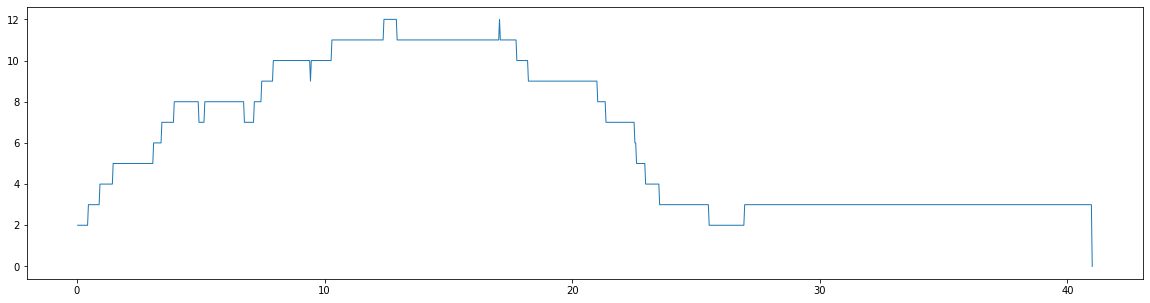

In [41]:
#Временой ряд
import pandas as pd
df = pd.DataFrame({'time': np.array([key for key in c_dict.keys()]), 'cnt': [value for value in c_dict.values()]})
plt.figure(figsize=(20, 5))
plt.plot(df.time, df.cnt, linewidth = 1)
plt.show()

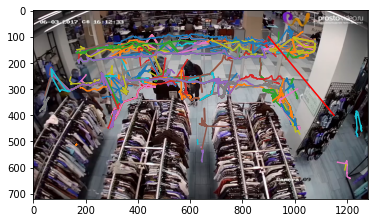

In [42]:
plt.imshow(first_img)
for k, v in objs.items():
  xs, ys = [], [] 
  for po in v:
    xs.append(po[0].x)
    ys.append(po[0].y)
  plt.plot(xs, ys)
plt.plot(x, y, color='r')
